# Библиотеки

In [54]:
from zlib import crc32

import numpy as np
import pandas as pd
import scipy.stats as st
import re
from IPython.display import clear_output
from functools import partial
import sprt
import scipy

# Код генерации выборки

In [2]:
EMAIL_REGEX = re.compile(r"[^@]+@phystech.edu")

def generate_dataset(code):
    rs = np.random.RandomState(code)
    proba = 0.01 * rs.randint(low = 55, high = 70)
    return 1.0*(rs.uniform(size = 5000) < proba)

# Генерация выборки для вашей почты

<span style="color:red">
    ВАЖНО!
    Почта, которую укажете ниже и почта с которой Вы отправляете домашнее задание должна совпадать!
    В момент проверки задания алгоритм генерирует выборку на основе почты из анкеты!
</span>

Внимательно проверьте почту для которой выполняется задание!

In [3]:
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
assert EMAIL_REGEX.match(task['mail']), 'Not a mail in the phystech.edu domain'
task['id'] = crc32(task['mail'].encode('utf-8'))
task['data'] = generate_dataset(task['id'])

task

Enter your mail: bogdanov.ai@phystech.edu


{'mail': 'bogdanov.ai@phystech.edu',
 'id': 1162440694,
 'data': array([1., 0., 0., ..., 1., 0., 0.])}

# Работа с выборкой

In [37]:
data = task['data']

## Оценка вероятности методом максимального правдоподобия. (Ответ округлите до 3-х знаков после запятой).

In [38]:
p = data.sum()/len(data)
print(f'Оценка вероятности методом максимального правдоподобия: {p:.3f}.')

Оценка вероятности методом максимального правдоподобия: 0.640.


## С помощью последовательного анализа проверить нулевую гипотезу p0=0.5 против p1, полученной методом максимального правдоподобия. Использовать библиотеку sprt с alpha=beta=0.05. Гипотеза принимается?

Decision:	Reject

      values     lower     upper
n                               
4991  3196.0  2845.021  2855.240
4992  3196.0  2845.592  2855.811
4993  3197.0  2846.163  2856.383
4994  3198.0  2846.734  2856.954
4995  3199.0  2847.305  2857.525
4996  3200.0  2847.876  2858.096
4997  3200.0  2848.447  2858.667
4998  3201.0  2849.018  2859.238
4999  3201.0  2849.589  2859.809
5000  3201.0  2850.160  2860.380


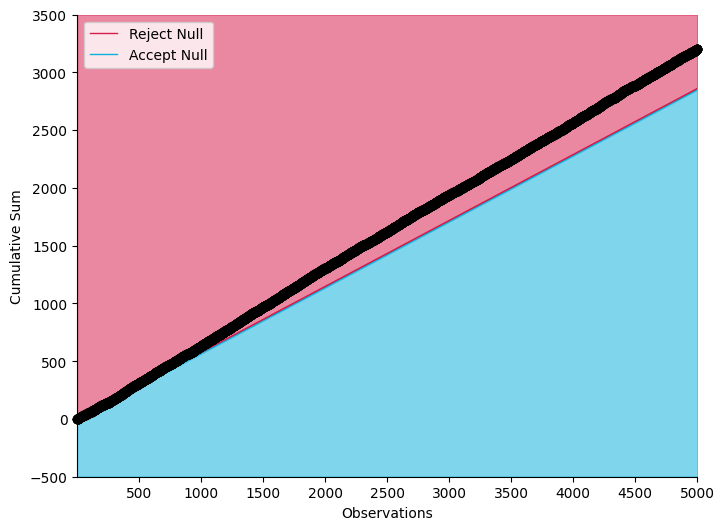

In [44]:
alpha = beta = 0.05
p0 = 0.5

test = sprt.SPRTBinomial(alpha=alpha, beta=beta, h0=p0, h1=p, values=data)
test.plot()

In [45]:
print(f'{test.decision}')

Reject


## Какое минимальное количество итераций требуется для вынесения решения по данной гипотезе?

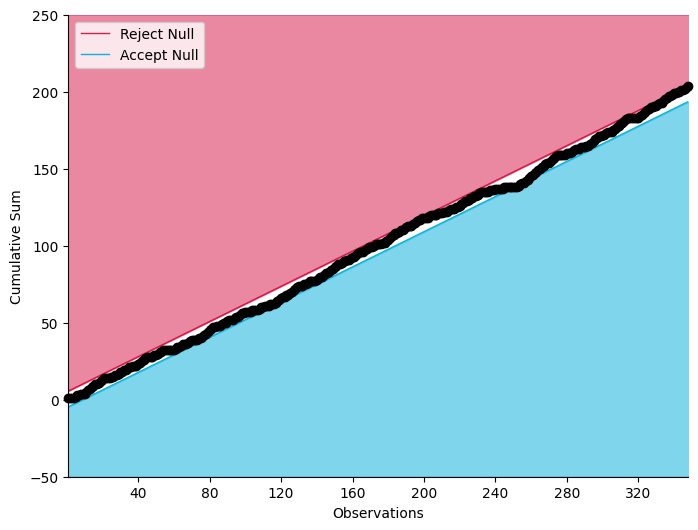

Гипотеза отклоняется за 349 итераций.


In [46]:
i = 1
test = sprt.SPRTBinomial(alpha=alpha, beta=beta, h0=0.5, h1=p, values=data[:i])

while test.decision != 'Reject':
    test = sprt.SPRTBinomial(alpha=alpha, beta=beta, h0=0.5, h1=p, values=data[:i])
    i += 1
clear_output(wait=True)

test.plot()
print(f'Гипотеза отклоняется за {i} итераций.')

## Матождиание требуемого количества итераций (для решения уравнения со слайдов можно использовать scipy.optimize.root_scalar). За истинное значение параметра принимать МП-оценку. Округлять до целого числа в меньшую сторону.

In [56]:
def expectation(p, p0, alpha, beta, h):
    A = (1 - beta) / alpha
    B = beta / (1 - alpha)
    L = (A**h - 1) / (A**h - B**h)
    
    result = (L * np.log(B) + (1 - L) * np.log(A)) / (p * np.log(p/p0) + (1 - p) * np.log((1 - p)/(1 - p0)) )
    
    return result

In [57]:
def f(x, p, p0):
    return (1 - ((1 - p) / (1 - p0))**x) / ((p / p0)**x - ((1 - p) / (1 - p0))**x) - p

In [63]:
f_new = partial(f, p=p, p0=p0)
solution = scipy.optimize.root_scalar(f_new, bracket=[-5, 5], method='brentq')

print('\n Математическое ожидание числа итераций:', int(expectation(p, p0, alpha, beta, solution.root)))


 Математическое ожидание числа итераций: 66
